In [1]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import time
import sys
import os

import seaborn as sns
import gensim
import datetime
import pytz

import django
import platform

if platform.node() == "srv-mcc-apsis":
    sys.path.append('/home/muef/tmv/BasicBrowser/')
else:
    # local paths
    sys.path.append('/Documents/Data/tmv/BasicBrowser/')

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

# import from appended path
import parliament.models as pm
from parliament.tasks import do_search, run_tm
import cities.models as cmodels
import scoping.models as sm
from django.contrib.auth.models import User
from tmv_app.models import *
import twitter.models as tm
from utils.tm_mgmt import update_topic_scores
from utils.text import *
from django.db.models import Q, Count, Func, F, Sum, Value, Case, When, IntegerField
from django.db.models.functions import Trunc, TruncDay

idx = pd.IndexSlice

In [2]:
df_twittersearches = pd.DataFrame(data=tm.TwitterSearch.objects.all().order_by('id').values())
pd.set_option('display.max_rows', 100)
df_twittersearches

id                                   string  \
0     1                                    kohle   
1     2                          Kohlekommission   
2     3                                     coal   
3     4                         @badulrichmartha   
4     5                                sustainab   
5     6                           geoengineering   
6     7                    "climate engineering"   
7     8                     "negative emissions"   
8     9                 "carbon dioxide removal"   
9    10                            "co2 removal"   
10   11                         "carbon removal"   
11   12                      "co2 sequestration"   
12   13                   "carbon sequestration"   
13   14           "carbon dioxide sequestration"   
14   15                 "greenhouse gas removal"   
15   16                            "ghg removal"   
16   17                  "planetary engineering"   
17   18                                #CO2Preis   
18   19                               #CO2Preise   
19   20                               #CO2Steuer   
20   21                              #CO2Steuern   
21   22                               #CO2Abgabe   
22   23                                   #EUETS   
23   24                                     #ETS   
24   25                         #Emissionshandel   
25   26                       #Klimaschutzgesetz   
26   27                         #Kohlekommission   
27   28                           #Kohleausstieg   
28   29                              #Klimakrise   
29   30                             #Klimawandel   
30   31                             #Klimaschutz   
31   32                             #Hambibleibt   
32   33                              "co2 preis"   
33   34                             "co2 steuer"   
34   35                        Klimaschutzgesetz   
35   36                        Zertifikatehandel   
36   37                              Klimasteuer   
37   39                                co2 preis   
38   41                            carbonpricing   
39   43                            co2bepreisung   
40   46                           @GretaThunberg   
41   48                          "Kohleausstieg"   
42   49                          #Kohlekopromiss   
43   51                                co2steuer   
44   55                              #co2 steuer   
45   57                              wasserstoff   
46   58                                 hydrogen   
47   59                                    Klima   
48   60                             Erderwärmung   
49   61                        globale Erwärmung   
50   62                          Treibhauseffekt   
51   63                                kohlefrei   
52   68                        #FridaysForFuture   
53   69                             Energiewende   
54   70                               Wärmewende   
55   71                            Verkehrswende   
56   72                           Industriewende   
57   73                                     #FFF   
58   77                            #Klimapolitik   
59   78                             #EUGreenDeal   
60   79                       climate mitigation   
61   80                       climate adaptation   
62   81                           climate policy   
63   82                           climate action   
64   83                         "climate change"   
65   84                         "carbon pricing"   
66   85                           "carbon price"   
67   86                              "co2 price"   
68   87                            "co2 pricing"   
69   88                      "emissions trading"   
70   89                       "emission trading"   
71   90                              Klimaschutz   
72   91                           Klimaanpassung   
73   92                             Klimapolitik   
74   93                              Klimawandel   
75   94              Klima anpassungKlimapolitik   
7

In [3]:
# searches for creating a sample

# all related to geoengineering and cdr currently in database
#search_ids = [6,7,8,9,10, 11, 12, 13,14,15,16, 17]

search_ids = [6,7,17]

# identify search results

In [4]:
df_twittersearches = pd.DataFrame(data=tm.TwitterSearch.objects.filter(id__in=search_ids).order_by('id').values())
df_twittersearches

id                   string                   scrape_fetched  \
0   6           geoengineering 2021-04-21 01:16:37.308677+00:00   
1   7    "climate engineering" 2021-04-21 01:16:37.308677+00:00   
2  17  "planetary engineering" 2021-04-21 01:16:37.308677+00:00   

                             until                            since  \
0 2022-03-02 01:16:37.308677+00:00 2009-11-05 09:31:44.480805+00:00   
1 2022-03-02 01:16:37.308677+00:00 2009-11-05 09:31:44.480805+00:00   
2 2022-03-02 01:16:37.308677+00:00 2009-11-05 09:31:44.480805+00:00   

                      search_since  project_id  
0 2021-04-15 14:34:24.751810+00:00           2  
1 2021-04-15 14:34:24.751810+00:00           2  
2 2021-04-15 14:34:24.751810+00:00           2

In [5]:
df_twittersearches["string"].values

array(['geoengineering', '"climate engineering"',
       '"planetary engineering"'], dtype=object)

# create new sample for labeling

In [2]:
p = sm.Project.objects.get(pk=299) # 299 is id of geoengineering project
tags = sm.Tag.objects.filter(project=p)
dos = sm.DocOwnership.objects.filter(tag__in=tags)

In [8]:
# Filter out retweets and empty tweets
# and filter out older, very new tweets and non-english tweets

searches = tm.TwitterSearch.objects.filter(id__in=search_ids)

# better use datetime.datetime.strptime('2019-10-01-+0000', '%Y-%m-%d-%z')?
start_date = datetime.datetime(2018, 1, 1, tzinfo=datetime.timezone.utc)
end_date = datetime.datetime(2021, 12, 31, tzinfo=datetime.timezone.utc)
# time from twitter is given in utc, see https://developer.twitter.com/en/docs/twitter-ads-api/timezones

sids=list(tm.Status.searches.through.objects.filter(
    twittersearch__in=searches,
    status__created_at__gte = start_date,
    status__created_at__lte = end_date,
    status__lang = 'en'
).exclude(status__text="…"
         ).exclude(status__retweeted=True
                  ).exclude(status__text__startswith="RT "
                            ).values_list('status_id',flat=True))

print(len(sids))
np.save("geoengineering_sids.npy", np.array(sids))

201073


In [12]:
sids = np.load("geoengineering_sids.npy").tolist()

In [14]:
# draw random sample from tweets that have not been looked at already

sids = set(sids) - set(dos.values_list('tweet_id',flat=True))

sample = random.sample(list(
    sids
), 100)

texts = tm.Status.objects.filter(id__in=sample).values_list('text', 'created_at')
for text in texts:
    print(text)

('ALREADY HAPPENING!!! #Geoengineering https://t.co/BVAdDbcFQ0', datetime.datetime(2018, 1, 8, 10, 25, 16, tzinfo=<UTC>))
("#GeoEngineering Think sun-deflecting space mirrors or chemically altered clouds. And because these are sci-fi movies, it's assumed that these grand experiments in geoengineering will go horribly wrong. The fiction, new evidence suggests,… https://t.co/eYj3xsqfiG via #hng #news https://t.co/HIuMK4DHDe", datetime.datetime(2018, 2, 10, 16, 10, 7, tzinfo=<UTC>))
("It's getting worse? \n#Acceleration of #climatechange #SeaLevelsRise #KeepitintheGround #GlaciersGoing @EPA #AFRAID2ACT #ItsNATIONALSECURITYStupid #RISKYbiz #NoPlan #GlobalWarming #geoengineering #CantHIDETemps #NoHidingENVDamage https://t.co/0GAGqvbFrm https://t.co/pKH0otZSpD", datetime.datetime(2018, 2, 13, 1, 13, 58, tzinfo=<UTC>))
('https://t.co/LjecwXrRQg\nWhy the ELITES will win\n#Geoengineering #PharmaLies#5GTakeover #MAGA #NoDACA#wethepeople @realDonaldTrump https://t.co/Ir8qQHk8MR', datetime.datetim

In [15]:
np.save("geoengineering_sids_sample2.npy", np.array(sample))

In [16]:
# create new tag object for these
t, created = sm.Tag.objects.get_or_create(
    project=p,
    title="New sample of general geoengineering tweets (en, 2018-2021)"
)
print("created new tag object:", created)

# get users
users = sm.User.objects.filter(
    username__in=[
    "lueck@mcc-berlin.net",
    "galm",
    "repke@mcc-berlin.net",
    "lamw",
    "muef",
    "minj",
    "cmbaum@btech.au.dk",
    "SeanLow",
    "brutschin@iiasa.ac.at",
    "jcroberts4@wisc.edu"
    ]
)

# add sample to tag object
for s in sample:
    status = tm.Status.objects.get(pk=s)
    status.tag.add(t)
    for u in users:        
        do, created = sm.DocOwnership.objects.get_or_create(
            tag=t,
            user=u,
            tweet_id=s
        )
        
t.update_tag()
print("added sample to tag object for users:", users)

created new tag object: False
added sample to tag object for users: <QuerySet [<User: lueck@mcc-berlin.net>, <User: galm>, <User: repke@mcc-berlin.net>, <User: muef>, <User: lamw>, <User: minj>, <User: cmbaum@btech.au.dk>, <User: SeanLow>, <User: brutschin@iiasa.ac.at>]>


In [3]:
# update criteria text

p.criteria = "The tweet is relevant if it is about geoengineering in general or a GGR or SRM technology. It is not relevant if it is not related to such a topic, is spam or was generated by a bot."
p.save()

In [3]:
sample = np.load("geoengineering_sids_sample2.npy").tolist()
print(type(sample), type(sample[0]))

<class 'list'> <class 'int'>


In [5]:
# add more people

# create new tag object for these
t = sm.Tag.objects.get(
    project=p,
    title="New sample of general geoengineering tweets (en, 2018-2021)"
)
print(t)

# get users
users = sm.User.objects.filter(
    username__in=[
    "jcroberts4@wisc.edu"
    ]
)

# add sample to tag object
for s in sample:
    status = tm.Status.objects.get(pk=s)
    status.tag.add(t)
    for u in users:        
        do, created = sm.DocOwnership.objects.get_or_create(
            tag=t,
            user=u,
            tweet_id=s
        )
        
t.update_tag()
print("added sample to tag object for users:", users)

New sample of general geoengineering tweets (en, 2018-2021)
added sample to tag object for users: <QuerySet [<User: jcroberts4@wisc.edu>]>


In [15]:
# remove wrongly created DocOwnership objects

doos = sm.DocOwnership.objects.filter(tag__title="Sample of general geoengineering tweets (2018-2021)",
                               user__username="jcroberts4@wisc.edu")
print(doos.count())
doos.values_list('user__username', 'tag__title', 'tweet_id')

100


<QuerySet [('jcroberts4@wisc.edu', 'Sample of general geoengineering tweets (2018-2021)', 1149604593732505601), ('jcroberts4@wisc.edu', 'Sample of general geoengineering tweets (2018-2021)', 1419491449393930240), ('jcroberts4@wisc.edu', 'Sample of general geoengineering tweets (2018-2021)', 1107349701383331849), ('jcroberts4@wisc.edu', 'Sample of general geoengineering tweets (2018-2021)', 979360932743794688), ('jcroberts4@wisc.edu', 'Sample of general geoengineering tweets (2018-2021)', 1138932803309977600), ('jcroberts4@wisc.edu', 'Sample of general geoengineering tweets (2018-2021)', 1170048412261261312), ('jcroberts4@wisc.edu', 'Sample of general geoengineering tweets (2018-2021)', 1040655675599183873), ('jcroberts4@wisc.edu', 'Sample of general geoengineering tweets (2018-2021)', 1066312402516365312), ('jcroberts4@wisc.edu', 'Sample of general geoengineering tweets (2018-2021)', 1381264708670488579), ('jcroberts4@wisc.edu', 'Sample of general geoengineering tweets (2018-2021)', 11

In [17]:
#doos.delete()

(100, {'scoping.DocOwnership': 100})

# export labeling results

In [6]:
from django.contrib.postgres.aggregates import StringAgg
from django.db.models import Max, Subquery, OuterRef, Exists

pid = 299

#response = HttpResponse(content_type='text/csv')
#response['Content-Disposition'] = 'attachment; filename="screened_tweets.csv"'

p = sm.Project.objects.get(pk=pid)
dos = sm.DocOwnership.objects.filter(tag__project=p, relevant__gt=0)
cat_refs = {}
annotations = {}

for c in sm.Category.objects.filter(project=p).exclude(name__icontains="<hidden>").order_by('level'):
    cat_refs[c.name] = sm.DocUserCat.objects.filter(
        tweet = OuterRef('tweet__pk'),
        user = OuterRef('user__pk'),
        category=c
    )
    annotations[f"{c.level} - {c.name}"] = Exists(cat_refs[c.name])
    
annotations["time_annotated"] = Subquery(sm.DocUserCat.objects.filter(
        tweet = OuterRef('tweet__pk'),
        user = OuterRef('user__pk')
    ).values("time")[:1])

cols = ['tweet__id','tweet__text','user__username', 'tag__title','relevant'] + list(annotations.keys())

notes = sm.Note.objects.filter(project=p).order_by('tweet_id').values('user__username','tweet__id').annotate(
    note__text=StringAgg("text","; ")
)

df = pd.DataFrame.from_dict(list(dos.annotate(**annotations).values(*cols)))[cols]

for annotation in list(annotations.keys())[:-1]:
    df[annotation] = df[annotation] * 1

note_df = pd.DataFrame.from_dict(notes)
if len(note_df) > 0:
    df = df.merge(note_df, how="left")

#df.to_csv('labeled_tweets_{}_{}.csv'.format(pid, datetime.datetime.today().strftime('%Y-%m-%d')))

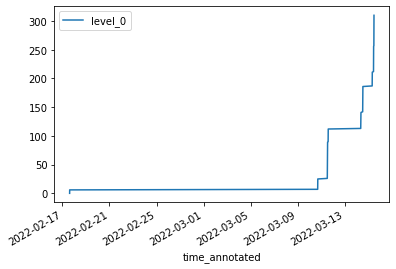

In [7]:
df.sort_values("time_annotated").reset_index().reset_index().plot(x="time_annotated", y="level_0")

In [8]:
#trimmed_sample = df[df["time_annotated"] >= datetime.datetime(2022, 3, 1,  tzinfo=pytz.UTC)]

sample = df[df["tag__title"] == "Sample of general geoengineering tweets (2018-2021)"]
sample = sample.sort_values(["tweet__id", "user__username"])
sample.to_csv('labeled_tweets_{}_{}.csv'.format(pid, datetime.datetime.today().strftime('%Y-%m-%d')))
sample.head()

tweet__id                                        tweet__text  \
268  950423612636450816  Geoengineering Watch Global Alert News, Januar...   
57   950423612636450816  Geoengineering Watch Global Alert News, Januar...   
273  955662117310423041  Researchers from the US say deliberately chang...   
62   955662117310423041  Researchers from the US say deliberately chang...   
216  957045355463426048  The engineers are painting our sky white. #che...   

    user__username                                         tag__title  \
268           galm  Sample of general geoengineering tweets (2018-...   
57            muef  Sample of general geoengineering tweets (2018-...   
273           galm  Sample of general geoengineering tweets (2018-...   
62            muef  Sample of general geoengineering tweets (2018-...   
216        SeanLow  Sample of general geoengineering tweets (2018-...   

     relevant  2 - Negative  2 - Neutral  2 - Positive  3 - Surprise  \
268         1             0            1             0             0   
57          1             1            0             0             0   
273         1             1            0             0             0   
62          1             1            0             0             0   
216         1             1            0             0             0   

     3 - Disgust  ...  3 - Fear  3 - Other or none  3 - Joy  4 - Neutral  \
268            0  ...         0                  1        0            0   
57             0  ...         0                  1        0            0   
273            0  ...         0                  1        0            0   
62             0  ...         0                  1        0            0   
216            1  ...         1                  0        0            0   

     4 - Pro  4 - Contra  5 - Yes  6 - Yes                   time_annotated  \
268        0           1        1        0 2022-03-15 11:39:03.848525+00:00   
57         0           1        1        0 2022-03-15 08:10:38.273027+00:00   
273        0           1        0        0 2022-03-15 11:37:37.711098+00:00   
62         0           1        0        0 2022-03-15 08:08:22.781998+00:00   
216        0           1        1        0 2022-03-11 12:44:46.380125+00:00   

     note__text  
268         NaN  
57          NaN  
273         NaN  
62          NaN  
216         NaN  

[5 rows x 22 columns]

In [9]:
sample.groupby("user__username")["tweet__id"].count()

user__username
SeanLow                  68
galm                    100
lueck@mcc-berlin.net     23
muef                    100
repke@mcc-berlin.net     20
Name: tweet__id, dtype: int64

# compare results

In [7]:
label_cols = ['relevant', '2 - Negative', '2 - Neutral', '2 - Positive', '3 - Surprise',
          '3 - Disgust', '3 - Sadness', '3 - Anger', '3 - Fear',
           '3 - Other or none', '3 - Joy', '4 - Neutral', '4 - Pro', '4 - Contra',
       '5 - Yes', '6 - Yes']
rename_cols = {'2 - Negative': "Sentiment - Negative",
               '2 - Neutral': 'Sentiment - Neutral',
               '2 - Positive': 'Sentiment - Positive',
               '3 - Surprise': 'Emotion - Surprise',
               '3 - Disgust': 'Emotion - Disgust',
               '3 - Sadness': 'Emotion - Sadness',
               '3 - Anger': 'Emotion - Anger',
               '3 - Fear': 'Emotion - Fear',
               '3 - Other or none': 'Emotion - Other or none',
               '3 - Joy': 'Emotion - Joy',
               '4 - Neutral': 'Stance - Neutral',
               '4 - Pro': 'Stance - Pro',
               '4 - Contra': 'Stance - Contra',
               '5 - Yes': 'Conspiracy - Yes',
               '6 - Yes': 'Bot/spam - Yes'}

In [8]:
labels = sample.set_index(["tweet__id", "user__username"])

In [9]:
labels = labels[label_cols].unstack("user__username")

In [10]:
text = sample[["tweet__id", "tweet__text"]].drop_duplicates().set_index("tweet__id")
text.columns = pd.MultiIndex.from_tuples([("text", "text")])

In [22]:
df = pd.merge(text, labels, left_index=True, right_index=True)
df = df.rename(columns=rename_cols)
df

text  \
                                                                  text   
tweet__id                                                                
950423612636450816   Geoengineering Watch Global Alert News, Januar...   
955662117310423041   Researchers from the US say deliberately chang...   
957045355463426048   The engineers are painting our sky white. #che...   
966491613689085952   https://t.co/VwVIzLyq62 \nWe're Baaaack; More ...   
980646113354031104   @SkyWeatherAUS WATCH &amp; Understand What You...   
...                                                                ...   
1429775474729828355  Solar geoengineering has the potential to coun...   
1440508327142694923  @CanaryCryRadio \n@Basil_Rosewater \n@FaceLike...   
1457377583738224642  All the accumulated CO2 in the atmosphere will...   
1464688685476040707  The Dimming, Full Length Climate Engineering D...   
1471588083145768963  If anyone needs more days off per week it's th...   

                    relevant                                 \
                     SeanLow galm lueck@mcc-berlin.net muef   
tweet__id                                                     
950423612636450816       NaN  1.0                  NaN  1.0   
955662117310423041       NaN  1.0                  NaN  1.0   
957045355463426048       1.0  1.0                  1.0  1.0   
966491613689085952       NaN  1.0                  NaN  2.0   
980646113354031104       1.0  1.0                  NaN  1.0   
...                      ...  ...                  ...  ...   
1429775474729828355      NaN  1.0                  NaN  1.0   
1440508327142694923      NaN  1.0                  NaN  1.0   
1457377583738224642      NaN  1.0                  NaN  1.0   
1464688685476040707      1.0  1.0                  1.0  1.0   
1471588083145768963      1.0  1.0                  NaN  1.0   

                                         Sentiment - Negative       \
                    repke@mcc-berlin.net              SeanLow galm   
tweet__id                                                            
950423612636450816                   NaN                  NaN  0.0   
955662117310423041                   NaN                  NaN  1.0   
957045355463426048                   NaN                  1.0  1.0   
966491613689085952                   NaN                  NaN  0.0   
980646113354031104                   NaN                  1.0  1.0   
...                                  ...                  ...  ...   
1429775474729828355                  NaN                  NaN  0.0   
1440508327142694923                  NaN                  NaN  1.0   
1457377583738224642                  NaN                  NaN  0.0   
1464688685476040707                  NaN                  1.0  1.0   
1471588083145768963                  NaN                  1.0  1.0   

                                               ... Conspiracy - Yes       \
                    lueck@mcc-berlin.net muef  ...          SeanLow galm   
tweet__id                                      ...                         
950423612636450816                   NaN  1.0  ...              NaN  1.0   
955662117310423041                   NaN  1.0  ...              NaN  0.0   
957045355463426048                   1.0  0.0  ...              1.0  1.0   
966491613689085952                   NaN  0.0  ...              NaN  1.0   
980646113354031104                   NaN  1.0  ...              1.0  1.0   
...                                  ...  ...  ...              ...  ...   
1429775474729828355                  NaN  0.0  ...              NaN  0.0   
1440508327142694923                  NaN  0.0  ...              NaN  1.0   
1457377583738224642                  NaN  0.0  ...              NaN  0.0   
1464688685476040707                  0.0  0.0  ...              1.0  1.0   
1471588083145768963                  NaN  0.0  ...              1.0  1.0   

                                                                    \
                    lueck@mcc-

In [23]:
# agreement

def agreement(x):
    if len(x.dropna().unique()) > 1:
        return False
    else:
        return True

for label in (list(rename_cols.values()) + ["relevant"]):
    slice_df = df[idx[label]]
    df[(label, "agreement")] =  slice_df.apply(agreement, axis=1)

In [24]:
#df.sort_index(axis=1)
df.to_excel('comparison_sheet_{}_{}.xlsx'.format(pid, datetime.datetime.today().strftime('%Y-%m-%d')))

In [ ]:
# todo: adapt for tweets

def compare_tag_tweets(tag,p):
    
    docids = DocOwnership.objects.filter(tag=tag).values_list('doc__id', flat=True)
    docs = Doc.objects.filter(pk__in=docids)
    if not DocOwnership.objects.filter(doc__in=docs, query=q,relevant__gt=0, tag=tag).exists():
        return pd.DataFrame()

    cats = Category.objects.filter(project=p).exclude(name__icontains="hidden>")
    df = pd.DataFrame.from_dict(
        DocUserCat.objects.filter(
            category__in=cats,
            doc__in=docs
        ).values(
            'doc__id',
            'category__name',
            'category__level',
            'user__username'
        )
    )
    df['category__level'] = df['category__level'].astype(str)
    df['cat'] = df[['category__level','category__name','user__username']].apply(lambda x: ' - '.join(x), axis=1)
    df['val'] = 1
    
    df['cname'] = df[['category__level','category__name']].apply(lambda x: ' - '.join(x), axis=1)
    
    dudf_wide = df[['doc__id','user__username','cname','val']].pivot_table(index=['doc__id','user__username'],columns="cname", values="val").fillna(0)
    dudf_wide_r = dudf_wide.reset_index()
    dudf_wide_r.columns = ["doc__id",'user__username'] + list(dudf_wide.columns)
    dudf_expanded = dudf_wide_r.melt(id_vars=["doc__id","user__username"]).sort_values(['doc__id','variable'])
    dudf_expanded['mean'] = dudf_expanded.groupby(['doc__id','variable']).transform('mean')
    dudf_expanded = dudf_expanded.rename(columns={
        "doc__id":"doc_id",
        "variable":"category",
        "user__username":"user"
    })
    
    wide_df = (df[['doc__id','cat','val']]
           .drop_duplicates()
           .pivot(index='doc__id',columns="cat",values='val')
           .fillna(0)
          )
    cs = wide_df.columns
    wide_df['doc_id'] = wide_df.index
    wide_df = wide_df.reset_index(drop=True)
    
    do_df = pd.DataFrame.from_dict(
        DocOwnership.objects.filter(doc__in=docs, query=q,relevant__gt=0).values(
            'doc__id',
            'user__username',
            'relevant'
        )
    )
    do_df = (
        do_df.drop_duplicates(['doc__id','user__username'])
        .pivot(index='doc__id',columns="user__username",values="relevant")
    )
    rs = []
    for c in do_df.columns:
        do_df = do_df.rename(columns={c: f'0 - relevant - {c}'})
        rs.append(f'0 - relevant - {c}')
    do_df['doc_id'] = do_df.index
    do_df = do_df.reset_index(drop=True)
    
    doc_df = pd.DataFrame.from_dict(
        Doc.objects.filter(pk__in=docs).values(
            'id','title','content'
        )
    ).rename(columns={"id":"doc_id"})
    
    dudf_expanded = pd.merge(dudf_expanded,doc_df, how="outer")[["doc_id","title","content","user","category","value","mean"]]
    
    df = pd.merge(doc_df,pd.merge(wide_df,do_df,how="outer"))[["doc_id","title","content"]+list(rs)+list(cs)]

    #df = df.loc[:,(df.sum(axis=0) != 0)]
    

    
    df.to_csv(f'{tag.title}_comparison.csv', index=False)

    writer = pd.ExcelWriter(f'{tag.title}_comparison.xlsx', engine='xlsxwriter')
    df.to_excel(writer, index=False, sheet_name='comparison')
    dudf_expanded.to_excel(writer, index=False, sheet_name='by_cat_comparison')
    workbook = writer.book
    worksheet = writer.sheets['comparison']
    wrap_format = workbook.add_format({'text_wrap': True})
    worksheet.set_column('D:ZZ', 20)
    worksheet.set_column('C:C', 80, wrap_format)
    worksheet.set_column('B:B', 30, wrap_format)

    for col_num, value in enumerate(df.columns.values):
        worksheet.write(0,col_num,value.split('@')[0],wrap_format)

    for i,row in df.iterrows():
        try:
            worksheet.set_row(i+1,15+15*len(row['content'])//150)
        except:
            worksheet.set_row(i+1,15)
    worksheet.set_row(0, 40)
    worksheet.freeze_panes(1,3)
    
    worksheet = writer.sheets['by_cat_comparison']
    
    worksheet.set_column('D:ZZ', 15)
    worksheet.set_column('C:C', 40)
    worksheet.set_column('B:B', 40, wrap_format)
    worksheet.set_column('D:E', 40, wrap_format)
    
    for i,row in dudf_expanded.iterrows():
        worksheet.set_row(i+1,17+17*len(row['title'])//60)
        
    worksheet.conditional_format(f'G1:G{i+1}', {
        'type': '3_color_scale',
        'min_value': 0,
        'mid_value': 0.5,
        'max_value': 1
    })
    
    writer.save()
    
    return df

df = compare_tag(tag, p)
print(df.shape)
df.head()